In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import probplot
from scipy import stats
import statsmodels.api as sm
from statsmodels.sandbox.predict_functional import predict_functional



# Landscape of the Full IEDB Dataset

In [43]:
data_full=pd.read_csv("IEDB_20130222_mhci_FULL.csv")

print("Checking null values:")
data_full.isnull().sum()

print("Checking if peptide seq is unique:")
print("Count of rows: ", data_full.shape[0])
print("Count of unique seqs: ", len(data_full.sequence.unique()))

Checking null values:
Checking if peptide seq is unique:
Count of rows:  186684
Count of unique seqs:  43361


## What percent of data in the full dataset is human?

84.3%

Counts of seqs in the dataset. Total sample size= 186684
human         157325
macaque        14028
mouse           9787
chimpanzee      3712
cow             1268
pig              389
rat              146
gorilla           15
horse             14
Name: species, dtype: int64


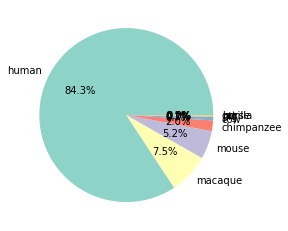

In [44]:
sns.set_palette("Set3")
plt.pie(data_full.species.value_counts(), labels=[
    "human", "macaque", "mouse", "chimpanzee", "cow", "pig", "rat", "gorilla", "horse"
], autopct='%1.1f%%')

print("Counts of seqs in the dataset. Total sample size=", data_full.shape[0])
print(data_full.species.value_counts())


## What percentage of data in the full dataset is human HLA0201?

Among a total of 157325 samples in the subset of data where "species=human":

HLA A*0201 samples occupy 7.7% of the the human subset, and 6.5% of the full data set

Counts of seqs in the human data subset
Sample sdize of the human data subset: 157325
HLA-A*02:01    12160
HLA-A*03:01     7358
HLA-A*11:01     6399
HLA-A*02:03     6303
HLA-A*31:01     5713
               ...  
HLA-A24            2
HLA-B27            2
HLA-B*35:08        1
HLA-B8             1
HLA-A1             1
Name: allele, Length: 119, dtype: int64


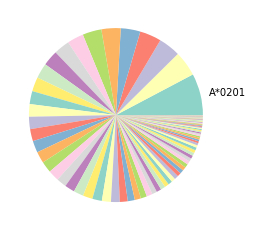

In [45]:
data_hu=data_full[data_full.species=="human"]

labels=["A*0201"]+["" for i in range (0, 118)]

sns.set_palette("Set3")
plt.pie(data_hu.allele.value_counts(), labels=labels)

print("Counts of seqs in the human data subset")
print("Sample sdize of the human data subset:",data_hu.shape[0] )
print(data_hu.allele.value_counts())

# Import human HLA-A02:01 9mer data subset

Features:
1. all human
2. HLA 0201 only
3. 9mer only
4. Contains the following predictions:

  - ANN v4.0,IEDB (IC50)
  - MHCFlurry v1.4.3 (IC50)
  - NetMHCpan-BA v4.0 (IC50)
  - NetMHCpan-EL v4.0
    - Score: higher the better
    - Rank: lower the better: Strong binders are defined as having %rank<0.5, and weak binders with %rank<2

In [46]:
data=pd.read_csv("IEDB_20130222_mhci_huA0201_9mer_PREDICTED_4m.csv")
data.head()


,Unnamed: 0,species,allele,peptide_length,sequence,inequality,ic50,ic50_percentile,ann_ic50,ann_percentile,flurry_ic50,flurry_low,flurry_high,flurry_percentile,panBA_ic50,panBA_rank,panEL_score,panEL_rank
0,0,human,HLA-A*02:01,9,AIIDYIAYM,=,1.0,1.961109,8.71,7.363827,16.003015,5.702752,58.844314,0.097625,7.7,0.07,0.948038,0.03
1,1,human,HLA-A*02:01,9,AIYDTMQYV,=,1.0,1.961109,7.43,6.176113,13.920045,5.443097,58.564548,0.078125,6.2,0.05,0.973237,0.02
2,2,human,HLA-A*02:01,9,ALATFTVNI,<,1.0,1.961109,16.70,12.396420,24.355410,10.626195,65.569848,0.161750,9.1,0.08,0.940067,0.03
3,3,human,HLA-A*02:01,9,ALDEGLLPV,=,1.0,1.961109,3.43,1.430781,7.091334,4.432173,11.182979,0.021500,3.8,0.03,0.977313,0.01
4,4,human,HLA-A*02:01,9,ALFPIIWAL,=,1.0,1.961109,3.54,1.613081,5.817067,2.931410,9.138727,0.012250,4.4,0.03,0.979226,0.01


# Check data quality

1. Total sample size
2. How many samples have ambigous (">" or "<" in the "equality" column) or confirmed IC50 values ("=" in the "equality column)
3. How many samples have unique peptide sequence

In [47]:
# sample size
print("Sample size: ", data.shape[0])

# Missing values
print("\nMissing values: ")
print(data.isnull().sum())

# Inequality
print("\nCounts by inequality:")
print(data.groupby("inequality").size())

# Unique peptide seq
print("\nCounts of unique peptide seq: ", len(data.sequence.unique()))

Sample size:  9051

Missing values: 
Unnamed: 0           0
species              0
allele               0
peptide_length       0
sequence             0
inequality           0
ic50                 0
ic50_percentile      0
ann_ic50             0
ann_percentile       0
flurry_ic50          0
flurry_low           0
flurry_high          0
flurry_percentile    0
panBA_ic50           0
panBA_rank           0
panEL_score          0
panEL_rank           0
dtype: int64

Counts by inequality:
inequality
<     198
=    6038
>    2815
dtype: int64

Counts of unique peptide seq:  9051


# Cleaning up

## Log transformation of ic50
- Column **ic50_ln**: transform column **ic50** using natural log
- Column **ann_ic50_ln**: transform column **ic50_ann** using natural log

In [48]:
#Perform ln transformation on ic50 values
data["ic50_ln"]=np.log(data.ic50)
data["ann_ic50_ln"]=np.log(data.ann_ic50)
data["flurry_ic50_ln"]=np.log(data.flurry_ic50)
data["panBA_ic50_ln"]=np.log(data.panBA_ic50)
data.head()

,Unnamed: 0,species,allele,peptide_length,sequence,inequality,ic50,ic50_percentile,ann_ic50,ann_percentile,...,flurry_high,flurry_percentile,panBA_ic50,panBA_rank,panEL_score,panEL_rank,ic50_ln,ann_ic50_ln,flurry_ic50_ln,panBA_ic50_ln
0,0,human,HLA-A*02:01,9,AIIDYIAYM,=,1.0,1.961109,8.71,7.363827,...,58.844314,0.097625,7.7,0.07,0.948038,0.03,0.0,2.164472,2.772777,2.041220
1,1,human,HLA-A*02:01,9,AIYDTMQYV,=,1.0,1.961109,7.43,6.176113,...,58.564548,0.078125,6.2,0.05,0.973237,0.02,0.0,2.005526,2.633330,1.824549
2,2,human,HLA-A*02:01,9,ALATFTVNI,<,1.0,1.961109,16.70,12.396420,...,65.569848,0.161750,9.1,0.08,0.940067,0.03,0.0,2.815409,3.192754,2.208274
3,3,human,HLA-A*02:01,9,ALDEGLLPV,=,1.0,1.961109,3.43,1.430781,...,11.182979,0.021500,3.8,0.03,0.977313,0.01,0.0,1.232560,1.958873,1.335001
4,4,human,HLA-A*02:01,9,ALFPIIWAL,=,1.0,1.961109,3.54,1.613081,...,9.138727,0.012250,4.4,0.03,0.979226,0.01,0.0,1.264127,1.760796,1.481605


# General Descriptive Stats

## IC50 distribution of samples with IC50 > some number

min=5000

count      2815.000000
mean      29648.021334
std       23635.027880
min        5000.000000
25%       20000.000000
50%       20000.000000
75%       20000.000000
max      250000.000000
Name: ic50, dtype: float64


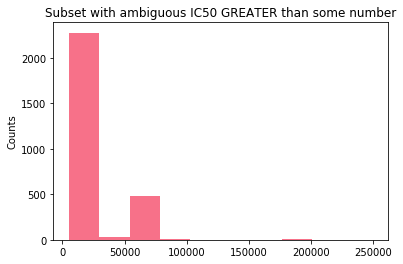

In [49]:
sns.set_palette("husl")

data_gr=data[data["inequality"]==">"]
plt.hist(data_gr.ic50)
plt.title("Subset with ambiguous IC50 GREATER than some number")
plt.ylabel("Counts")

print(data_gr.ic50.describe())

## IC50 distribution of samples with IC50 < some number

max=10

count    198.000000
mean       1.045455
std        0.639602
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max       10.000000
Name: ic50, dtype: float64


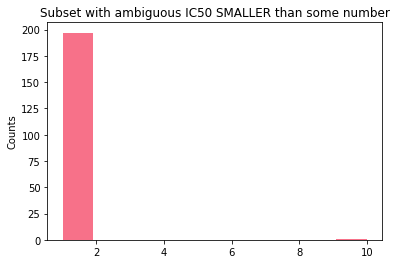

In [50]:
data_sm=data[data["inequality"]=="<"]
plt.hist(data_sm.ic50)
plt.title("Subset with ambiguous IC50 SMALLER than some number")
plt.ylabel("Counts")

print(data_sm.ic50.describe())

## IC50 distribution of samples with IC50 = some number

IC50 range: [1, 1.43e7]

count    6.038000e+03
mean     3.032939e+04
std      2.451403e+05
min      1.000000e+00
25%      2.700000e+01
50%      4.269671e+02
75%      8.744115e+03
max      1.427660e+07
Name: ic50, dtype: float64


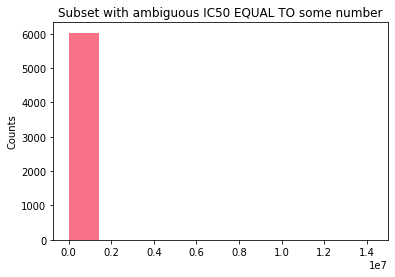

In [51]:
data_eq=data[data["inequality"]=="="]
plt.hist(data_eq.ic50)
plt.title("Subset with ambiguous IC50 EQUAL TO some number")
plt.ylabel("Counts")

print(data_eq.ic50.describe())

## Checking normality assumption of the experimental IC50 values, in samples with IC50 = some number

IC50 values in the range (0, 500] do not follow normal distribution

Text(0.5, 1.0, 'Experimental IC50 values <= 500 ')

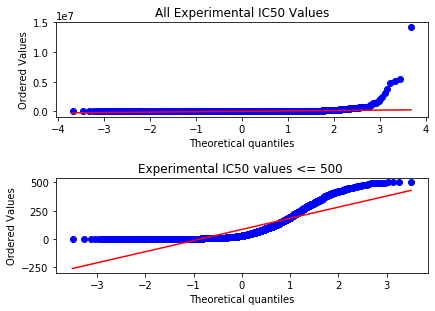

In [52]:
#Plot all experimental IC50 values
plt.subplot(2, 1, 1)
probplot(data_eq.ic50, dist=stats.norm,plot=plt)
plt.title("All Experimental IC50 Values")

plt.tight_layout(h_pad=3, w_pad=None)
criteria=data_eq.ic50<=500
plt.subplot(2, 1, 2)
probplot(data_eq[criteria].ic50, dist=stats.norm,plot=plt)
plt.title("Experimental IC50 values <= 500 ")

# Evaluation of predictions from IEDB ANN model

## Show linear-linear correlation of predicted IC50 values and experimental IC50 values

Inclusion Criteria:

- Only peptides with confirmed IC50 ("inequality' is "=") are selected

Model:
- linear-linear regression model: $$y=a+bx$$

Result:
- No clear **linear-linear** correlation between experimental IC50 and ANN predicted IC50

In [53]:
def plotbins(pred, act, df, alg=None,c="orangered"):
    """
    generate scatter plots for different IC50 bins
    :param pred: str
        column with predicted IC50 values
    :param act: str
        column with actual IC50 values
    :param df: DataFrame
        DataFrame object that contains the pred and actual columns
    :param alg: str
        Algorithm used for prediction
    :param c: str
        Color to use for teh plot
    :return: matplotlib object
        5 figures, each represents a bin (all, 0-10 nM, 10-50 nM, 50-500 nM, and 500-5e4 nM). Axis: x: predicted IC50, y: actual IC50
    """

    plt.figure(figsize=(10, 10))

    #plot all experimental IC50
    plt.subplot(3, 2, 1)
    sns.scatterplot(pred, act, data=df, color=c, alpha=0.3)
    plt.title("No Strata")
    plt.xlim((0, 50000))
    plt.ylim((0, 50000))
    plt.xlabel("IC50, Predicted by: "+alg)
    plt.ylabel("IC50, Actual")

    #plot Experimental IC50 between (0, 10]
    plt.subplot(3, 2, 2)
    plt.tight_layout(h_pad=3, w_pad=4)
    criteria=data_eq.ic50<=10
    sns.scatterplot(pred,act, data=df[criteria], color=c, alpha=0.3)
    plt.title("Actual IC50: 0-10 nM")
    plt.xlim((0, 10))
    plt.xlabel("IC50, Predicted by: "+alg)
    plt.ylabel("IC50, Actual")

    #plot Experimental IC50 between (10, 50]
    plt.subplot(3, 2, 3)
    criteria=(data_eq.ic50>10) & (data_eq.ic50<=50)
    sns.scatterplot(pred, act, data=df[criteria], color=c, alpha=0.3)
    plt.xlim(10, 50)
    plt.title("Actual IC50: 10-50 nM")
    plt.xlabel("IC50, Predicted by: "+alg)
    plt.ylabel("IC50, Actual")

    #Plot Experimental IC50 between (50, 500]
    plt.subplot(3, 2, 4)
    criteria=(data_eq.ic50>50) & (data_eq.ic50<=500)
    sns.scatterplot(pred, act, data=df[criteria], color=c, alpha=0.3)
    plt.xlim((50, 500))
    plt.title("Actual IC50: 50-500 nM")
    plt.xlabel("IC50, Predicted by: "+alg)
    plt.ylabel("IC50, Actual")

    #Plot Experimental IC50 between 500 and 5e4
    plt.subplot(3, 2, 5)
    criteria=(data_eq.ic50>500) & (data_eq.ic50<50000)
    sns.scatterplot(pred, act, data=df[criteria], color=c, alpha=0.3)
    plt.title("Actual IC50: 500 - 5e4 nM")
    plt.xlim((500,50000))
    plt.xlabel("IC50, Predicted by: "+alg)
    plt.ylabel("IC50, Actual")


### 1. pred vs actual: ANN4.0 (linear-linear model)

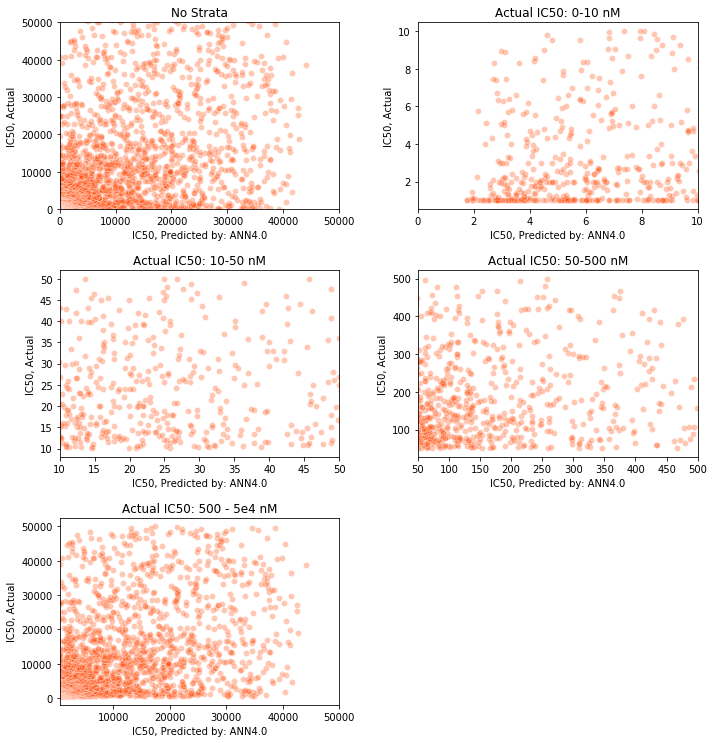

In [54]:
plotbins("ann_ic50", "ic50", data_eq, alg="ANN4.0")

#plt.savefig("1.png")


### 2. pred vs actual: MHCFlurry (linear-linear model)

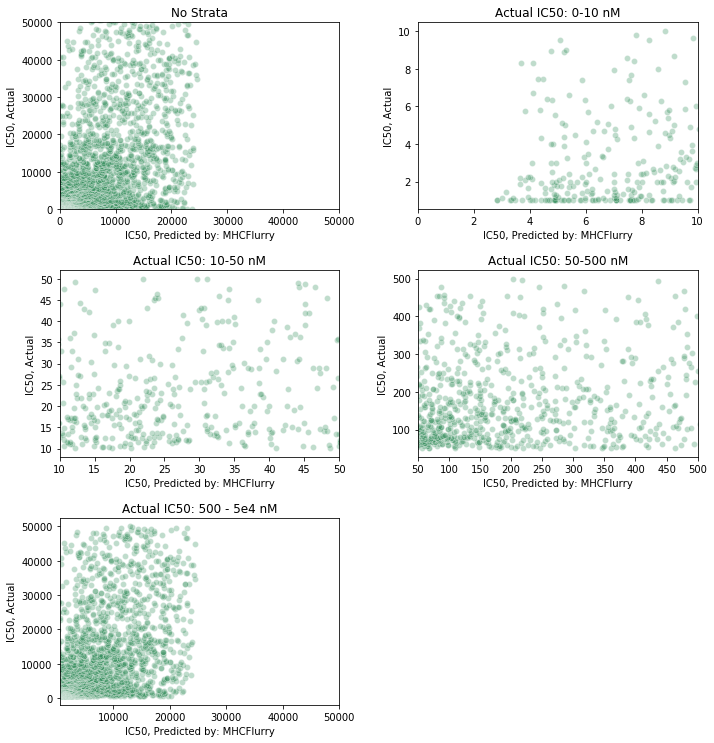

In [55]:
plotbins("flurry_ic50", "ic50", data_eq, alg="MHCFlurry", c="seagreen")

#plt.savefig("2.png")


### 3. pred vs actual: NetMHCpan-BA (linear-linear model)

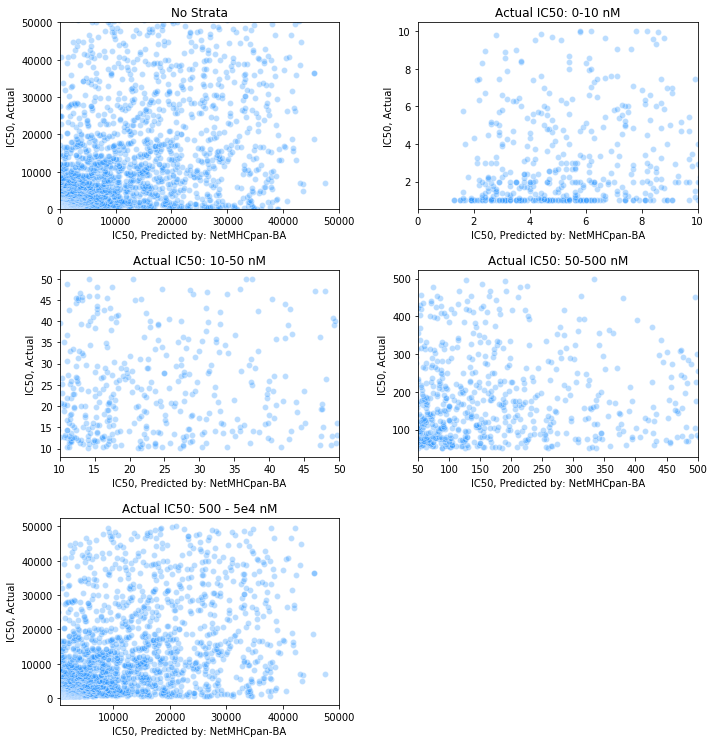

In [56]:
plotbins("panBA_ic50", "ic50", data_eq, alg="NetMHCpan-BA", c="dodgerblue")

#plt.savefig("3.png")


## Show log-log correlation of predicted IC50 values and experimental IC50 values

Criteria:

- Only peptides with confirmed IC50 ("inequality' is "=") are selected

Method:
- Testing using log-log regression model: $\ln(y)=a+b\ln(x)$

Result:
-

In [57]:
def plotbins_x(pred, act, df, alg=None,c="orangered"):
    """
    generate scatter plots for different IC50 bins, based on log-transformed IC50 values

    :param pred: str
        column with predicted IC50 values, log-transformed
    :param act: str
        column with actual IC50 values, log-transformed
    :param df: DataFrame
        DataFrame object that contains the pred and actual columns
    :param alg: str
        Algorithm used for prediction
    :param c: str
        Color to use for teh plot

    :return: matplotlib object
        5 figures, each represents a bin (all, 0-10 nM, 10-50 nM, 50-500 nM, and 500-5e4 nM). Axis: x: log-transformed predicted IC50, y: log-transformed actual IC50
    """

    plt.figure(figsize=(10, 10))

    #plot all experimental IC50
    plt.subplot(3, 2, 1)
    sns.scatterplot(pred, act, data=df, color=c, alpha=0.3)
    plt.title("No Strata")
    # plt.xlim((0, 11))
    # plt.ylim((0, 11))
    plt.xlabel("Log-Transformed IC50, Predicted by: "+alg)
    plt.ylabel("Log-Transformed IC50, Actual")

    #plot Experimental IC50 between (0, 10]
    plt.subplot(3, 2, 2)
    plt.tight_layout(h_pad=3, w_pad=4)
    criteria=data_eq.ic50<10
    sns.scatterplot(pred,act, data=df[criteria], color=c,alpha=0.3)
    plt.title("Actual IC50: 0-10 nM")
    plt.xlim((0, np.log(10)))
    plt.xlabel("Log-Transformed IC50, Predicted by: "+alg)
    plt.ylabel("Log-Transformed IC50, Actual")

    #plot Experimental IC50 between (10, 50]
    plt.subplot(3, 2, 3)
    criteria=(data_eq.ic50>10) & (data_eq.ic50<=50)
    sns.scatterplot(pred, act, data=df[criteria], color=c,alpha=0.3)
    plt.xlim((np.log(10), np.log(50)))
    plt.title("Actual IC50: 10-50 nM")
    plt.xlabel("Log-Transformed IC50, Predicted by: "+alg)
    plt.ylabel("Log-Transformed IC50, Actual")

    #Plot Experimental IC50 between (50, 500]
    plt.subplot(3, 2, 4)
    criteria=(data_eq.ic50>50) & (data_eq.ic50<=500)
    sns.scatterplot(pred, act, data=df[criteria], color=c,alpha=0.3)
    plt.xlim((np.log(50), np.log(500)))
    plt.title("Actual IC50: 50-500 nM")
    plt.xlabel("Log-Transformed IC50, Predicted by: "+alg)
    plt.ylabel("Log-Transformed IC50, Actual")

    #Plot Experimental IC50 between 500 and 5e4
    plt.subplot(3, 2, 5)
    criteria=(data_eq.ic50>500) & (data_eq.ic50<5*10**4)
    sns.scatterplot(pred, act, data=df[criteria], color=c,alpha=0.3)
    plt.title("Actual IC50: 500 - 5e4 nM")
    plt.xlim((np.log(500), np.log(5*10**4)))
    plt.xlabel("Log-Transformed IC50, Predicted by: "+alg)
    plt.ylabel("Log-Transformed IC50, Actual")




### 1. ln(pred) vs ln(actual): ANN4.0

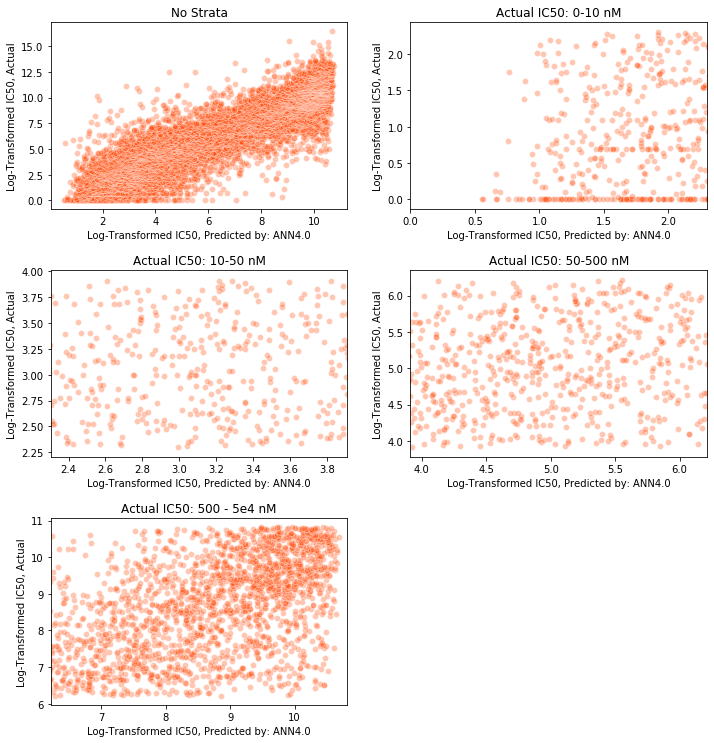

In [58]:
plotbins_x("ann_ic50_ln", "ic50_ln", data_eq, alg="ANN4.0")

#plt.savefig("4.png")


### 2. ln(pred) vs ln(actual): MHCFlurry

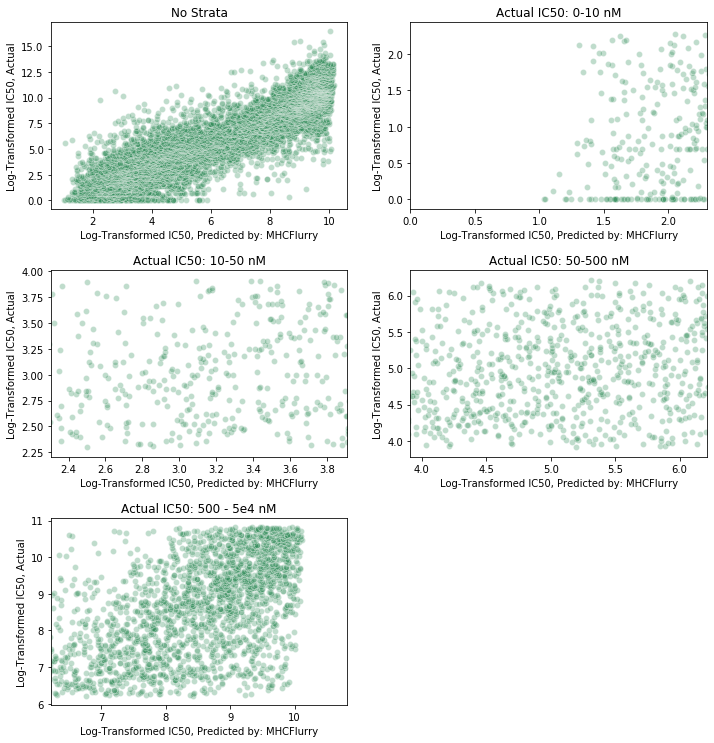

In [59]:
plotbins_x("flurry_ic50_ln", "ic50_ln", data_eq, alg="MHCFlurry", c="seagreen")


### 3. ln(pred) vs ln(actual): NetMHCpan-BA

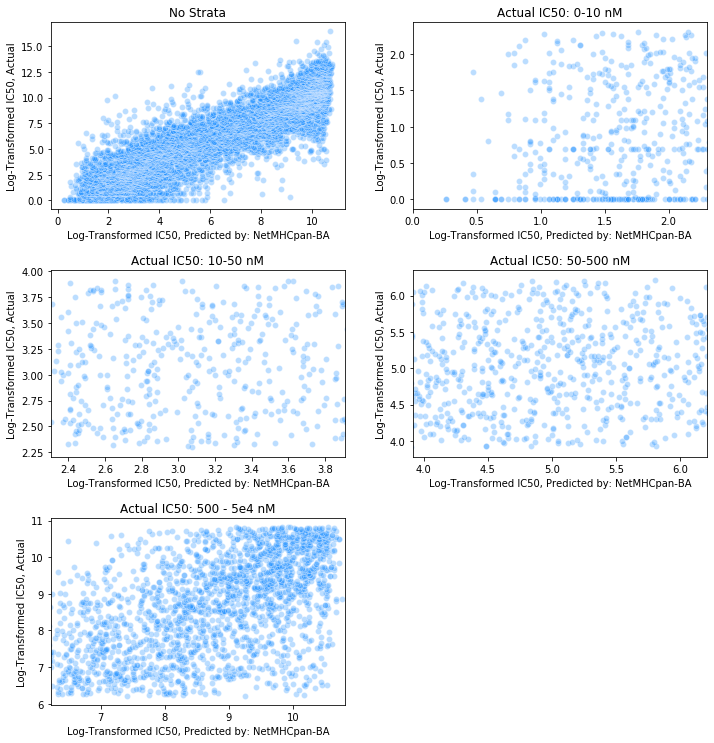

In [60]:
plotbins_x("panBA_ic50_ln", "ic50_ln", data_eq, alg="NetMHCpan-BA", c="dodgerblue")


## Perform Linear Regression on "IC50 Predicted vs IC50 Actual"

### OLS: Predicted vs Actual IC50, ANN4.0

In [61]:
model1=sm.OLS.from_formula("ic50_ln ~ ann_ic50_ln", data=data_eq)
result1=model1.fit()
result1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                ic50_ln   R-squared:                       0.728
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                 1.614e+04
Date:                Thu, 19 Mar 2020   Prob (F-statistic):               0.00
Time:                        00:00:48   Log-Likelihood:                -12180.
No. Observations:                6038   AIC:                         2.436e+04
Df Residuals:                    6036   BIC:                         2.438e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.1130      0.055     -2.070      0.039      -0.220      -0.006
ann_ic50_ln     1.0141      0.008    127.047      0.000       0.998       1.030
==============================================================================
Omnibus:                      111.231   Durbin-Watson:                   1.320
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              224.032
Skew:                          -0.057   Prob(JB):                     2.25e-49
Kurtosis:                       3.937   Cond. No.                         16.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/usr/local/anaconda3/envs/pyrosetta/lib/python3.7/site-packages/statsmodels/sandbox/predict_functional.py:171: ValueWarning: 'ann_ic50', 'inequality', 'Unnamed: 0', 'panBA_ic50_ln', 'panEL_rank', 'ann_percentile', 'peptide_length', 'panEL_score', 'flurry_percentile', 'ic50', 'allele', 'panBA_ic50', 'species', 'flurry_low', 'flurry_high', 'flurry_ic50_ln', 'ic50_percentile', 'sequence', 'flurry_ic50', 'panBA_rank' in data frame but not in summaries or values.
  ValueWarning)


Text(0, 0.5, 'Log-Transformed IC50, Actual')

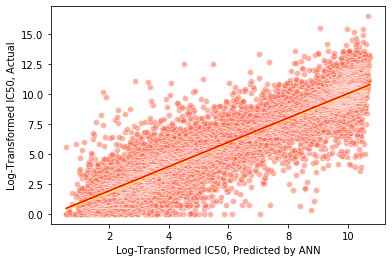

In [62]:
pred1, cb1, fv1 = predict_functional(result1,"ann_ic50_ln", ci_method="pointwise")

fig1=sns.scatterplot("ann_ic50_ln", "ic50_ln", data=data_eq, alpha=0.5, color="tomato")
fig1=sns.lineplot(fv1, pred1, color="red")
fig1.fill_between(fv1, cb1[:,0], cb1[:, 1], color="yellow", alpha=0.5)
plt.xlabel("Log-Transformed IC50, Predicted by ANN")
plt.ylabel("Log-Transformed IC50, Actual")


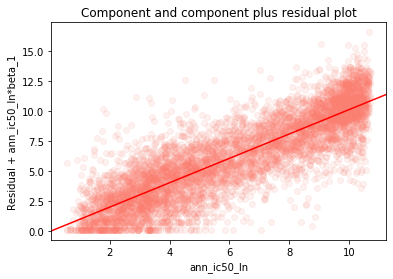

In [63]:
ax=plt.axes()

sm.graphics.plot_ccpr(result1,"ann_ic50_ln", ax)

ax.lines[0].set_alpha(0.1)
ax.lines[0].set_color("salmon") 
ax.lines[1].set_color("red") 

#plt.savefig("8.png")


### OLS: Predicted vs Actual IC50, MHCFurry

In [64]:
model2=sm.OLS.from_formula("ic50_ln ~ flurry_ic50_ln", data=data_eq)
result2=model2.fit()
result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                ic50_ln   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                 1.697e+04
Date:                Thu, 19 Mar 2020   Prob (F-statistic):               0.00
Time:                        00:00:49   Log-Likelihood:                -12070.
No. Observations:                6038   AIC:                         2.414e+04
Df Residuals:                    6036   BIC:                         2.416e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.1707      0.061    -19.276      0.000      -1.290      -1.052
flurry_ic50_ln     1.1584      0.009    130.255      0.000       1.141       1.176
==============================================================================
Omnibus:                      114.759   Durbin-Watson:                   1.334
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              236.821
Skew:                          -0.045   Prob(JB):                     3.76e-52
Kurtosis:                       3.966   Cond. No.                         18.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/usr/local/anaconda3/envs/pyrosetta/lib/python3.7/site-packages/statsmodels/sandbox/predict_functional.py:171: ValueWarning: 'ann_ic50', 'inequality', 'Unnamed: 0', 'panBA_ic50_ln', 'panEL_rank', 'ann_percentile', 'peptide_length', 'panEL_score', 'flurry_percentile', 'ic50', 'allele', 'panBA_ic50', 'species', 'flurry_low', 'flurry_high', 'ann_ic50_ln', 'ic50_percentile', 'sequence', 'flurry_ic50', 'panBA_rank' in data frame but not in summaries or values.
  ValueWarning)


Text(0, 0.5, 'Log-Transformed IC50, Actual')

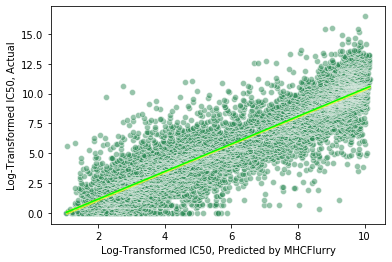

In [65]:
pred2, cb2, fv2 = predict_functional(result2,"flurry_ic50_ln", ci_method="simultaneous")

fig2=sns.scatterplot("flurry_ic50_ln", "ic50_ln", data=data_eq, alpha=0.5, color="seagreen")
fig2=sns.lineplot(fv2, pred2, color="lime")
fig2.fill_between(fv2, cb2[:,0], cb2[:, 1], color="yellow", alpha=0.5)
plt.xlabel("Log-Transformed IC50, Predicted by MHCFlurry")
plt.ylabel("Log-Transformed IC50, Actual")

#plt.savefig("9.png")


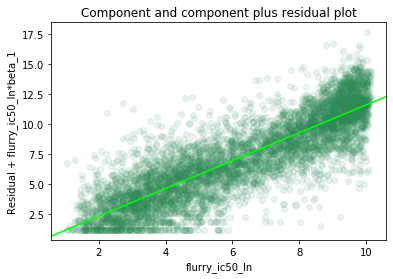

In [66]:
ax=plt.axes()

sm.graphics.plot_ccpr(result2,"flurry_ic50_ln", ax)

ax.lines[0].set_alpha(0.1)
ax.lines[0].set_color("seagreen") 
ax.lines[1].set_color("lime") 

#plt.savefig("10.png")


### OLS: Predicted vs Actual IC50, NetMHC-BA

In [67]:
model3=sm.OLS.from_formula("ic50_ln ~ panBA_ic50_ln", data=data_eq)
result3=model3.fit()
result3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                ic50_ln   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                 1.817e+04
Date:                Thu, 19 Mar 2020   Prob (F-statistic):               0.00
Time:                        00:00:49   Log-Likelihood:                -11915.
No. Observations:                6038   AIC:                         2.383e+04
Df Residuals:                    6036   BIC:                         2.385e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.0825      0.051     -1.605      0.108      -0.183       0.018
panBA_ic50_ln     1.0102      0.007    134.809      0.000       0.996       1.025
==============================================================================
Omnibus:                      115.921   Durbin-Watson:                   1.351
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              231.088
Skew:                          -0.082   Prob(JB):                     6.60e-51
Kurtosis:                       3.944   Cond. No.                         16.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/usr/local/anaconda3/envs/pyrosetta/lib/python3.7/site-packages/statsmodels/sandbox/predict_functional.py:171: ValueWarning: 'ann_ic50', 'inequality', 'Unnamed: 0', 'panEL_rank', 'ann_percentile', 'peptide_length', 'panEL_score', 'flurry_percentile', 'ic50', 'allele', 'panBA_ic50', 'species', 'flurry_low', 'flurry_high', 'flurry_ic50_ln', 'ann_ic50_ln', 'ic50_percentile', 'sequence', 'flurry_ic50', 'panBA_rank' in data frame but not in summaries or values.
  ValueWarning)


Text(0, 0.5, 'Log-Transformed IC50, Actual')

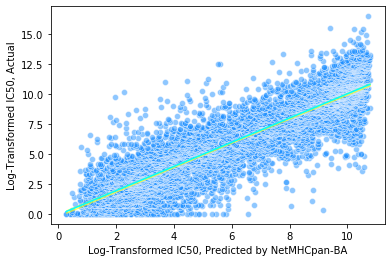

In [68]:
pred3, cb3, fv3 = predict_functional(result3,"panBA_ic50_ln", ci_method="simultaneous")

fig3=sns.scatterplot("panBA_ic50_ln", "ic50_ln", data=data_eq, alpha=0.5, color="dodgerblue")
fig3=sns.lineplot(fv3, pred3, color="cyan")
fig3.fill_between(fv3, cb3[:,0], cb3[:, 1], color="yellow", alpha=0.5)
plt.xlabel("Log-Transformed IC50, Predicted by NetMHCpan-BA")
plt.ylabel("Log-Transformed IC50, Actual")

#plt.savefig("11.png")


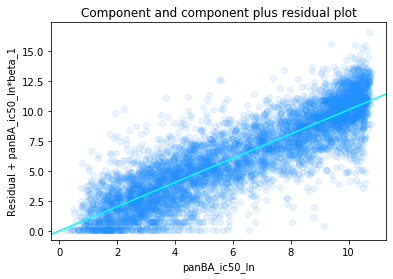

In [69]:
ax=plt.axes()

sm.graphics.plot_ccpr(result3,"panBA_ic50_ln", ax)

ax.lines[0].set_alpha(0.1)
ax.lines[0].set_color("dodgerblue") 
ax.lines[1].set_color("cyan") 

#plt.savefig("12.png")


# Stratify IC50 values into bins. How good is ANN at predicting the bins?

Strata of IC50:
- bin 0: (0, 10]
- bin 1: (10, 50]
- bin 2: (50, 500]
- bin 3: (500, $\infty$]

## Stratify experimental and predicted IC50 values into 5 bins

Column:
- **ic50_x**: converted ic50_x scores based on >, < and = signs. For rows with > signs, **ic50_x=ic50+0.1** For rows with < signs, **ic50_x=ic50-0.1**.
- **ic50_g**: bins classified based on column **ic50_x**
- **ann_g**: bins classified based on column **ann_ic50**
- **flurry_g**: bins classified based on column **flurry_ic50**
- **panBA_g**: bins classified based on column **panBA_ic50**

In [70]:
lst=[]
for index, row in data.iterrows():
    if row["inequality"]=="=":
        lst.append(row["ic50"])
    elif row["inequality"] == ">":
        lst.append(row["ic50"]+0.1)
    else:
        lst.append(row["ic50"]-0.1)

data["ic50_x"]=lst


data["ic50_g"]=pd.cut(data.ic50_x, [0, 10, 50, 500, float("inf")],
                      labels=[0, 1, 2, 3])

data["ann_g"]=pd.cut(data.ann_ic50, [0, 10, 50, 500, float("inf")],
                      labels=[0, 1, 2, 3])

data["flurry_g"]=pd.cut(data.flurry_ic50, [0, 10, 50, 500, float("inf")],
                      labels=[0, 1, 2, 3])

data["panBA_g"]=pd.cut(data.panBA_ic50, [0, 10, 50, 500, float("inf")],
                      labels=[0, 1, 2, 3])

data.head()

,Unnamed: 0,species,allele,peptide_length,sequence,inequality,ic50,ic50_percentile,ann_ic50,ann_percentile,...,panEL_rank,ic50_ln,ann_ic50_ln,flurry_ic50_ln,panBA_ic50_ln,ic50_x,ic50_g,ann_g,flurry_g,panBA_g
0,0,human,HLA-A*02:01,9,AIIDYIAYM,=,1.0,1.961109,8.71,7.363827,...,0.03,0.0,2.164472,2.772777,2.041220,1.0,0,0,1,0
1,1,human,HLA-A*02:01,9,AIYDTMQYV,=,1.0,1.961109,7.43,6.176113,...,0.02,0.0,2.005526,2.633330,1.824549,1.0,0,0,1,0
2,2,human,HLA-A*02:01,9,ALATFTVNI,<,1.0,1.961109,16.70,12.396420,...,0.03,0.0,2.815409,3.192754,2.208274,0.9,0,1,1,0
3,3,human,HLA-A*02:01,9,ALDEGLLPV,=,1.0,1.961109,3.43,1.430781,...,0.01,0.0,1.232560,1.958873,1.335001,1.0,0,0,0,0
4,4,human,HLA-A*02:01,9,ALFPIIWAL,=,1.0,1.961109,3.54,1.613081,...,0.01,0.0,1.264127,1.760796,1.481605,1.0,0,0,0,0


## Caluclate Accuracy

### Overall Accuracy

In [71]:
import sklearn.metrics as skm
print("overall accuracy, ANN:       ", skm.accuracy_score(data.ic50_g, data.ann_g))
print("overall accuracy, MHCFlurry: ",skm.accuracy_score(data.ic50_g, data.flurry_g))
print("overall accuracy, MHCpan-BA: ", skm.accuracy_score(data.ic50_g, data.panBA_g))

overall accuracy, ANN:        0.760468456524141
overall accuracy, MHCFlurry:  0.7561595403822782
overall accuracy, MHCpan-BA:  0.7710750193348801


### Accuracy in Bins

In [72]:
bin0= data.ic50_g==0
bin1= data.ic50_g==1
bin2= data.ic50_g==2
bin3= data.ic50_g==3

method=["ANN"]*4 + ["MHCFlurry"]*4 + ["MHCpan-BA"]*4
bins=["Bin 0", "Bin 1", "Bin 2", "Bin 3"]*3

acc=[]
for m in ["ann_g", "flurry_g", "panBA_g"]:
    for bin in [bin0, bin1, bin2, bin3]:
        x=skm.accuracy_score(data[bin].ic50_g, data[bin][m])
        acc.append(x)


acc_res=pd.DataFrame({
    "Method": method,
    "Bins": bins,
    "Accuracy": acc
})

acc_res

,Method,Bins,Accuracy
0,ANN,Bin 0,0.452815
1,ANN,Bin 1,0.484848
2,ANN,Bin 2,0.468285
3,ANN,Bin 3,0.927260
4,MHCFlurry,Bin 0,0.283940
5,MHCFlurry,Bin 1,0.436869
6,MHCFlurry,Bin 2,0.545810
7,MHCFlurry,Bin 3,0.945272
8,MHCpan-BA,Bin 0,0.487583
9,MHCpan-BA,Bin 1,0.488636


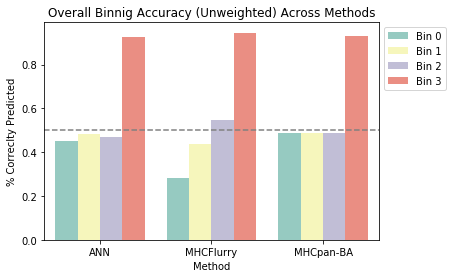

In [73]:
sns.set_palette("Set3")
fig=sns.barplot("Method", "Accuracy",hue="Bins", data=acc_res )
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.ylabel("% Correclty Predicted")
plt.title("Overall Binnig Accuracy (Unweighted) Across Methods")
plt.axhline(y=0.5, color="grey", linestyle="--")

plt.savefig("14.png", dpi=300)


## Plot Confusion Matrix

Text(0.5, 1, 'NetMHC-BA (norm.for true)')

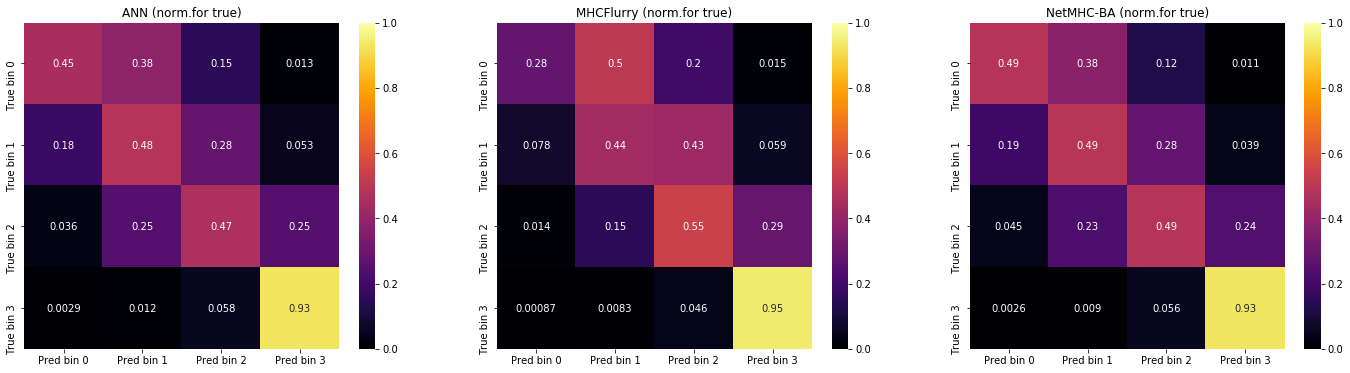

In [74]:
# Calculate confusion matrix for ANN, normalized for "true" values
x=skm.confusion_matrix(data.ic50_g, data.ann_g, normalize="true") #row: true,column: predicted
ann_cm=pd.DataFrame(x) 
ann_cm.index=["True bin 0", "True bin 1", "True bin 2", "True bin 3"]
ann_cm.columns=["Pred bin 0", "Pred bin 1", "Pred bin 2", "Pred bin 3"]

# Calculate confusion matrix for MHCFlurry, normalized for "true" values
x=skm.confusion_matrix(data.ic50_g, data.flurry_g, normalize="true") 
flurry_cm=pd.DataFrame(x) 
flurry_cm.index=["True bin 0", "True bin 1", "True bin 2", "True bin 3"]
flurry_cm.columns=["Pred bin 0", "Pred bin 1", "Pred bin 2", "Pred bin 3"]

# Calculate confusion matrix for NetMHCpan-BA, normalized for "true" values
x=skm.confusion_matrix(data.ic50_g, data.panBA_g, normalize="true") 
panBA_cm=pd.DataFrame(x) 
panBA_cm.index=["True bin 0", "True bin 1", "True bin 2", "True bin 3"]
panBA_cm.columns=["Pred bin 0", "Pred bin 1", "Pred bin 2", "Pred bin 3"]


#plot all 3 cm

plt.figure(figsize=(24, 6))
plt.subplot(1, 3, 1)
sns.heatmap(ann_cm, annot=True, vmin=0, vmax=1, cmap="inferno")
plt.title("ANN (norm.for true)")

plt.subplot(1, 3, 2)
sns.heatmap(flurry_cm, annot=True, vmin=0, vmax=1, cmap="inferno")
plt.title("MHCFlurry (norm.for true)")

plt.subplot(1, 3, 3)
sns.heatmap(panBA_cm, annot=True, vmin=0, vmax=1, cmap="inferno")
plt.title("NetMHC-BA (norm.for true)")

#plt.savefig("13.png", dpi=300)


## Plot ROC Curves

**Prepare table**

In [75]:
data.columns

Index(['Unnamed: 0', 'species', 'allele', 'peptide_length', 'sequence',
       'inequality', 'ic50', 'ic50_percentile', 'ann_ic50', 'ann_percentile',
       'flurry_ic50', 'flurry_low', 'flurry_high', 'flurry_percentile',
       'panBA_ic50', 'panBA_rank', 'panEL_score', 'panEL_rank', 'ic50_ln',
       'ann_ic50_ln', 'flurry_ic50_ln', 'panBA_ic50_ln', 'ic50_x', 'ic50_g',
       'ann_g', 'flurry_g', 'panBA_g'],
      dtype='object')

In [76]:
slice=data[["ic50_g", "ann_percentile", "flurry_percentile", "panBA_rank", "panEL_rank"]].copy()

slice

,ic50_g,ann_percentile,flurry_percentile,panBA_rank,panEL_rank
0,0,7.363827,0.097625,0.07,0.03
1,0,6.176113,0.078125,0.05,0.02
2,0,12.396420,0.161750,0.08,0.03
3,0,1.430781,0.021500,0.03,0.01
4,0,1.613081,0.012250,0.03,0.01
...,...,...,...,...,...
9046,3,80.841896,41.167500,58.00,66.00
9047,3,72.632858,8.903875,38.00,42.00
9048,3,95.193901,37.965500,67.00,43.00
9049,3,56.236880,10.845500,18.00,25.00


### All data, cutoff=500 nM

Assume bin 0, 1, 2 (IC50 0-500 nM) are "positive" conditions, and bin 3 (IC50 > 500 nM) is a "negative" condition

In [77]:
# define "positve" as if a peptide falls into bin 0-2. Otherwise define as "negative"

groups=np.array([1 if i<3 else 0 for i in slice.ic50_g])

**ROC of Percentile Ranked Scores, ANN, All peptide, Cutoff=500 nM**

Text(0.5, 1.0, 'NetMHCpan-EL(All,Cutoff=500 nM)')

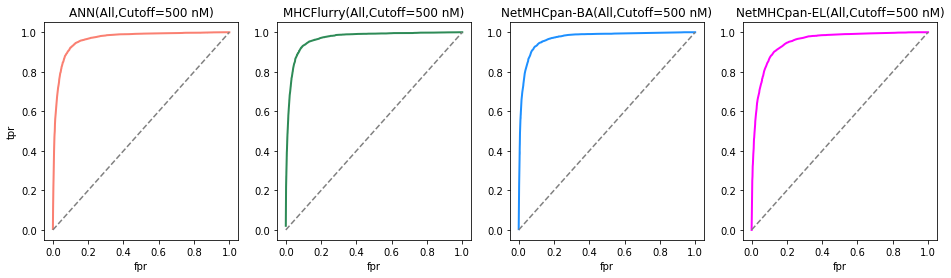

In [78]:
plt.figure(figsize=(16, 4))
plt.tight_layout(h_pad=3)

plt.subplot(1, 4, 1)
fpr, tpr, _=skm.roc_curve(groups, 100-slice.ann_percentile)
fig=sns.lineplot(x=fpr, y=tpr, color="salmon", lw=2)
sns.lineplot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1)) #dash line
fig.lines[1].set_linestyle("--")
fig.lines[1].set_color("grey")
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ANN(All,Cutoff=500 nM)")


plt.subplot(1, 4, 2)
fpr, tpr, _=skm.roc_curve(groups, 100-slice.flurry_percentile)
fig=sns.lineplot(x=fpr, y=tpr, color="seagreen", lw=2)
sns.lineplot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1)) #dash line
fig.lines[1].set_linestyle("--")
fig.lines[1].set_color("grey")
plt.xlabel("fpr")
plt.title("MHCFlurry(All,Cutoff=500 nM)")

plt.subplot(1, 4, 3)
fpr, tpr, _=skm.roc_curve(groups, 100-slice.panBA_rank)
fig=sns.lineplot(x=fpr, y=tpr, color="dodgerblue", lw=2)
sns.lineplot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1)) #dash line
fig.lines[1].set_linestyle("--")
fig.lines[1].set_color("grey")
plt.xlabel("fpr")
plt.title("NetMHCpan-BA(All,Cutoff=500 nM)")

plt.subplot(1, 4, 4)
fpr, tpr, _=skm.roc_curve(groups, 100-slice.panEL_rank)
fig=sns.lineplot(x=fpr, y=tpr, color="magenta", lw=2)
sns.lineplot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1)) #dash line
fig.lines[1].set_linestyle("--")
fig.lines[1].set_color("grey")
plt.xlabel("fpr")
plt.title("NetMHCpan-EL(All,Cutoff=500 nM)")

#plt.savefig("15.png", dpi=300)

In [79]:
#Print AUC socres
print("AUC Scores for ROC")
print("ANN:          ", skm.roc_auc_score(groups, 100-slice.ann_percentile))
print("MHCFlurry:    ", skm.roc_auc_score(groups, 100-slice.flurry_percentile))
print("NetMHCpan-BA: ", skm.roc_auc_score(groups, 100-slice.panBA_rank))
print("NetMHCpan-EL: ", skm.roc_auc_score(groups, 100-slice.panEL_rank))

AUC Scores for ROC
ANN:           0.9643469790128615
MHCFlurry:     0.9676191738052338
NetMHCpan-BA:  0.9687774127471976
NetMHCpan-EL:  0.9492001330979879


### IC50 in (0, 500]: cutoff=50 nM

First filter the data so that it includes only the samples with true IC50 between 0-500 nM (bin 0, 1, and 2). Samples <= 50 nM (bin 0, 1) will be considered as **positive**, while samples between 50-500 nM (bin 2) will be considred as **negative**

In [80]:
criteria=slice.ic50_g !=3
slice_500=slice[criteria]

# Define positive and negative gorups
groups2=np.array([1 if i<2 else 0 for i in slice_500.ic50_g])

Text(0.5, 1.0, 'NetMHCpan-EL(<500,Cutoff=50 nM)')

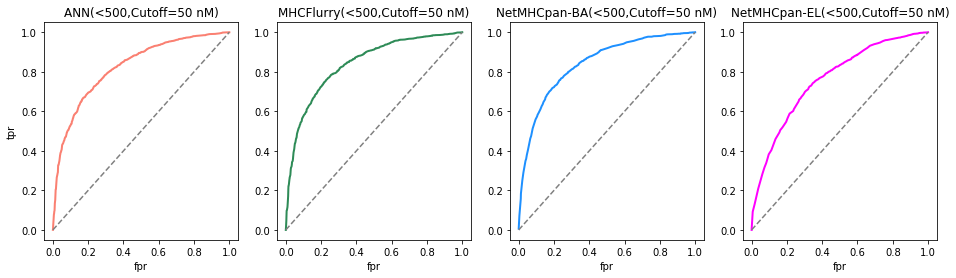

In [81]:
plt.figure(figsize=(16, 4))
plt.tight_layout(h_pad=3)

plt.subplot(1, 4, 1)
fpr, tpr, _=skm.roc_curve(groups2, 100-slice_500.ann_percentile)
fig=sns.lineplot(x=fpr, y=tpr, color="salmon", lw=2)
sns.lineplot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1)) #dash line
fig.lines[1].set_linestyle("--")
fig.lines[1].set_color("grey")
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ANN(<500,Cutoff=50 nM)")

plt.subplot(1, 4, 2)
fpr, tpr, _=skm.roc_curve(groups2, 100-slice_500.flurry_percentile)
fig=sns.lineplot(x=fpr, y=tpr, color="seagreen", lw=2)
sns.lineplot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1)) #dash line
fig.lines[1].set_linestyle("--")
fig.lines[1].set_color("grey")
plt.xlabel("fpr")
plt.title("MHCFlurry(<500,Cutoff=50 nM)")

plt.subplot(1, 4, 3)
fpr, tpr, _=skm.roc_curve(groups2, 100-slice_500.panBA_rank)
fig=sns.lineplot(x=fpr, y=tpr, color="dodgerblue", lw=2)
sns.lineplot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1)) #dash line
fig.lines[1].set_linestyle("--")
fig.lines[1].set_color("grey")
plt.xlabel("fpr")
plt.title("NetMHCpan-BA(<500,Cutoff=50 nM)")

plt.subplot(1, 4, 4)
fpr, tpr, _=skm.roc_curve(groups2, 100-slice_500.panEL_rank)
fig=sns.lineplot(x=fpr, y=tpr, color="magenta", lw=2)
sns.lineplot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1)) #dash line
fig.lines[1].set_linestyle("--")
fig.lines[1].set_color("grey")
plt.xlabel("fpr")
plt.title("NetMHCpan-EL(<500,Cutoff=50 nM)")

#plt.savefig("16.png", dpi=300)

In [82]:
#Print AUC socres
print("AUC Scores for ROC")
print("ANN:          ", skm.roc_auc_score(groups2, 100-slice_500.ann_percentile))
print("MHCFlurry:    ", skm.roc_auc_score(groups2, 100-slice_500.flurry_percentile))
print("NetMHCpan-BA: ", skm.roc_auc_score(groups2, 100-slice_500.panBA_rank))
print("NetMHCpan-EL: ", skm.roc_auc_score(groups2, 100-slice_500.panEL_rank))

AUC Scores for ROC
ANN:           0.8243181284259984
MHCFlurry:     0.8394962803445576
NetMHCpan-BA:  0.8393071652310102
NetMHCpan-EL:  0.7591869616288176


Text(0.5, 1, 'NetMHC-BA (norm.for true)')

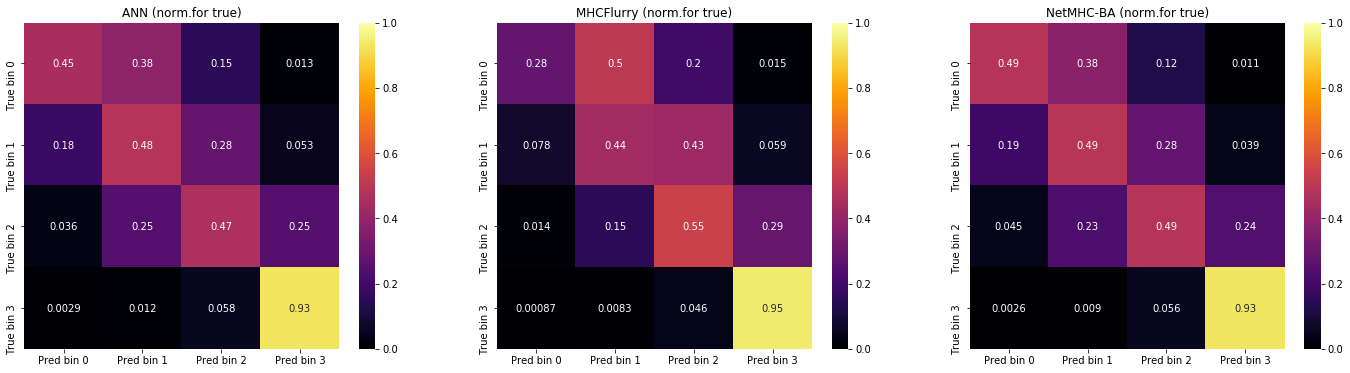

In [225]:
# Calculate confusion matrix for ANN, normalized for "true" values
x=skm.confusion_matrix(data.ic50_g, data.ann_g, normalize="true") #row: true,column: predicted
ann_cm=pd.DataFrame(x) 
ann_cm.index=["True bin 0", "True bin 1", "True bin 2", "True bin 3"]
ann_cm.columns=["Pred bin 0", "Pred bin 1", "Pred bin 2", "Pred bin 3"]

# Calculate confusion matrix for MHCFlurry, normalized for "true" values
x=skm.confusion_matrix(data.ic50_g, data.flurry_g, normalize="true") 
flurry_cm=pd.DataFrame(x) 
flurry_cm.index=["True bin 0", "True bin 1", "True bin 2", "True bin 3"]
flurry_cm.columns=["Pred bin 0", "Pred bin 1", "Pred bin 2", "Pred bin 3"]

# Calculate confusion matrix for NetMHCpan-BA, normalized for "true" values
x=skm.confusion_matrix(data.ic50_g, data.panBA_g, normalize="true") 
panBA_cm=pd.DataFrame(x) 
panBA_cm.index=["True bin 0", "True bin 1", "True bin 2", "True bin 3"]
panBA_cm.columns=["Pred bin 0", "Pred bin 1", "Pred bin 2", "Pred bin 3"]


#plot all 3 cm

plt.figure(figsize=(24, 6))
plt.subplot(1, 3, 1)
sns.heatmap(ann_cm, annot=True, vmin=0, vmax=1, cmap="inferno")
plt.title("ANN (norm.for true)")

plt.subplot(1, 3, 2)
sns.heatmap(flurry_cm, annot=True, vmin=0, vmax=1, cmap="inferno")
plt.title("MHCFlurry (norm.for true)")

plt.subplot(1, 3, 3)
sns.heatmap(panBA_cm, annot=True, vmin=0, vmax=1, cmap="inferno")
plt.title("NetMHC-BA (norm.for true)")

#plt.savefig("13.png", dpi=300)


## Plot ROC Curves

**Prepare table**

In [226]:
data.columns

Index(['Unnamed: 0', 'species', 'allele', 'peptide_length', 'sequence',
       'inequality', 'ic50', 'ic50_percentile', 'ann_ic50', 'ann_percentile',
       'flurry_ic50', 'flurry_low', 'flurry_high', 'flurry_percentile',
       'panBA_ic50', 'panBA_rank', 'panEL_score', 'panEL_rank', 'ic50_ln',
       'ann_ic50_ln', 'flurry_ic50_ln', 'panBA_ic50_ln', 'ic50_x', 'ic50_g',
       'ann_g', 'flurry_g', 'panBA_g'],
      dtype='object')

In [240]:
slice=data[["ic50_g", "ann_percentile", "flurry_percentile", "panBA_rank", "panEL_rank"]].copy()

slice

,ic50_g,ann_percentile,flurry_percentile,panBA_rank,panEL_rank
0,0,7.363827,0.097625,0.07,0.03
1,0,6.176113,0.078125,0.05,0.02
2,0,12.396420,0.161750,0.08,0.03
3,0,1.430781,0.021500,0.03,0.01
4,0,1.613081,0.012250,0.03,0.01
...,...,...,...,...,...
9046,3,80.841896,41.167500,58.00,66.00
9047,3,72.632858,8.903875,38.00,42.00
9048,3,95.193901,37.965500,67.00,43.00
9049,3,56.236880,10.845500,18.00,25.00


### All data, cutoff=500 nM

Assume bin 0, 1, 2 (IC50 0-500 nM) are "positive" conditions, and bin 3 (IC50 > 500 nM) is a "negative" condition

In [329]:
# define "positve" as if a peptide falls into bin 0-2. Otherwise define as "negative"

groups=np.array([1 if i<3 else 0 for i in slice.ic50_g])

**ROC of Percentile Ranked Scores, ANN, All peptide, Cutoff=500 nM**

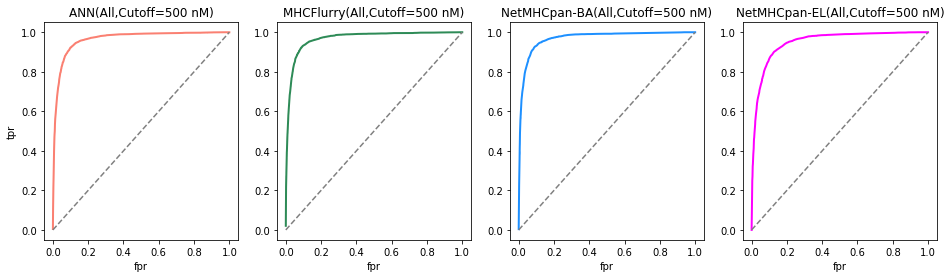

In [336]:
plt.figure(figsize=(16, 4))
plt.tight_layout(h_pad=3)

plt.subplot(1, 4, 1)
fpr, tpr, _=skm.roc_curve(groups, 100-slice.ann_percentile)
fig=sns.lineplot(x=fpr, y=tpr, color="salmon", lw=2)
sns.lineplot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1)) #dash line
fig.lines[1].set_linestyle("--")
fig.lines[1].set_color("grey")
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ANN(All,Cutoff=500 nM)")


plt.subplot(1, 4, 2)
fpr, tpr, _=skm.roc_curve(groups, 100-slice.flurry_percentile)
fig=sns.lineplot(x=fpr, y=tpr, color="seagreen", lw=2)
sns.lineplot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1)) #dash line
fig.lines[1].set_linestyle("--")
fig.lines[1].set_color("grey")
plt.xlabel("fpr")
plt.title("MHCFlurry(All,Cutoff=500 nM)")

plt.subplot(1, 4, 3)
fpr, tpr, _=skm.roc_curve(groups, 100-slice.panBA_rank)
fig=sns.lineplot(x=fpr, y=tpr, color="dodgerblue", lw=2)
sns.lineplot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1)) #dash line
fig.lines[1].set_linestyle("--")
fig.lines[1].set_color("grey")
plt.xlabel("fpr")
plt.title("NetMHCpan-BA(All,Cutoff=500 nM)")

plt.subplot(1, 4, 4)
fpr, tpr, _=skm.roc_curve(groups, 100-slice.panEL_rank)
fig=sns.lineplot(x=fpr, y=tpr, color="magenta", lw=2)
sns.lineplot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1)) #dash line
fig.lines[1].set_linestyle("--")
fig.lines[1].set_color("grey")
plt.xlabel("fpr")
plt.title("NetMHCpan-EL(All,Cutoff=500 nM)")

#plt.savefig("15.png", dpi=300)

In [256]:
#Print AUC socres
print("AUC Scores for ROC")
print("ANN:          ", skm.roc_auc_score(groups, 100-slice.ann_percentile))
print("MHCFlurry:    ", skm.roc_auc_score(groups, 100-slice.flurry_percentile))
print("NetMHCpan-BA: ", skm.roc_auc_score(groups, 100-slice.panBA_rank))
print("NetMHCpan-EL: ", skm.roc_auc_score(groups, 100-slice.panEL_rank))

AUC Scores for ROC
ANN:           0.9643469790128615
MHCFlurry:     0.9676191738052338
NetMHCpan-BA:  0.9687774127471976
NetMHCpan-EL:  0.9492001330979879


### IC50 in (0, 500]: cutoff=50 nM

First filter the data so that it includes only the samples with true IC50 between 0-500 nM (bin 0, 1, and 2). Samples <= 50 nM (bin 0, 1) will be considered as **positive**, while samples between 50-500 nM (bin 2) will be considred as **negative**

In [332]:
criteria=slice.ic50_g !=3
slice_500=slice[criteria]

# Define positive and negative gorups
groups2=np.array([1 if i<2 else 0 for i in slice_500.ic50_g])

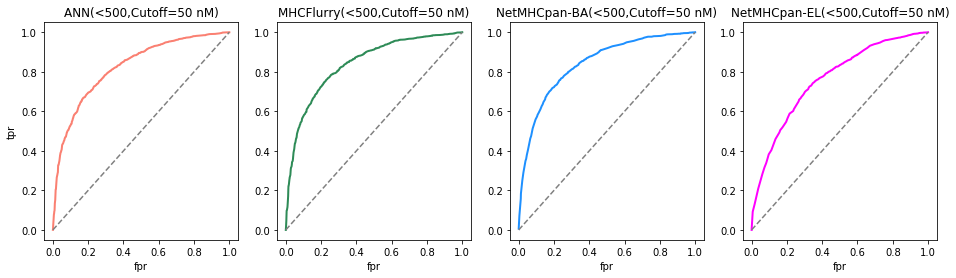

In [337]:
plt.figure(figsize=(16, 4))
plt.tight_layout(h_pad=3)

plt.subplot(1, 4, 1)
fpr, tpr, _=skm.roc_curve(groups2, 100-slice_500.ann_percentile)
fig=sns.lineplot(x=fpr, y=tpr, color="salmon", lw=2)
sns.lineplot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1)) #dash line
fig.lines[1].set_linestyle("--")
fig.lines[1].set_color("grey")
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ANN(<500,Cutoff=50 nM)")

plt.subplot(1, 4, 2)
fpr, tpr, _=skm.roc_curve(groups2, 100-slice_500.flurry_percentile)
fig=sns.lineplot(x=fpr, y=tpr, color="seagreen", lw=2)
sns.lineplot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1)) #dash line
fig.lines[1].set_linestyle("--")
fig.lines[1].set_color("grey")
plt.xlabel("fpr")
plt.title("MHCFlurry(<500,Cutoff=50 nM)")

plt.subplot(1, 4, 3)
fpr, tpr, _=skm.roc_curve(groups2, 100-slice_500.panBA_rank)
fig=sns.lineplot(x=fpr, y=tpr, color="dodgerblue", lw=2)
sns.lineplot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1)) #dash line
fig.lines[1].set_linestyle("--")
fig.lines[1].set_color("grey")
plt.xlabel("fpr")
plt.title("NetMHCpan-BA(<500,Cutoff=50 nM)")

plt.subplot(1, 4, 4)
fpr, tpr, _=skm.roc_curve(groups2, 100-slice_500.panEL_rank)
fig=sns.lineplot(x=fpr, y=tpr, color="magenta", lw=2)
sns.lineplot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1)) #dash line
fig.lines[1].set_linestyle("--")
fig.lines[1].set_color("grey")
plt.xlabel("fpr")
plt.title("NetMHCpan-EL(<500,Cutoff=50 nM)")

#plt.savefig("16.png", dpi=300)

In [335]:
#Print AUC socres
print("AUC Scores for ROC")
print("ANN:          ", skm.roc_auc_score(groups2, 100-slice_500.ann_percentile))
print("MHCFlurry:    ", skm.roc_auc_score(groups2, 100-slice_500.flurry_percentile))
print("NetMHCpan-BA: ", skm.roc_auc_score(groups2, 100-slice_500.panBA_rank))
print("NetMHCpan-EL: ", skm.roc_auc_score(groups2, 100-slice_500.panEL_rank))

AUC Scores for ROC
ANN:           0.8243181284259984
MHCFlurry:     0.8394962803445576
NetMHCpan-BA:  0.8393071652310102
NetMHCpan-EL:  0.7591869616288176
